In [2]:
pip install pyarrow --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn==0.24.1 --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 161.6 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xgboost --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install lightgbm --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install imbalanced-learn==0.8 --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install lime --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://ocnexus-srv01.fortisbank.com.pl:8443/repository/pypi-proxy/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import re

In [11]:
tran = pd.read_parquet("dspo_transactions.parquet")
clients = pd.read_csv("dspo_clients.csv",delimiter=',')
clients_test = pd.read_csv("dspo_clients_test.csv")
curr = pd.read_csv("dspo_currencies.csv")
tran_type = pd.read_csv("dspo_transactions_type.csv")

In [12]:
tran.head()

,Unnamed: 0,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id
0,0,57.07,95.0,57.07,95.0,129.0,20180208.0,64222014.0,-1.0
1,1,33.10,95.0,33.10,95.0,129.0,20180208.0,16178178.0,-1.0
2,2,11.12,95.0,11.12,95.0,129.0,20180208.0,74739022.0,-1.0
3,3,2869.56,95.0,2869.56,95.0,310.0,20180208.0,34298922.0,-1.0
4,4,2.50,95.0,2.50,95.0,136.0,20180208.0,16202593.0,-1.0


In [13]:
tran.shape
tran.describe()

,Unnamed: 0,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,prod_trans_type_id,date,debit_cst_id,credit_cst_id
count,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06,8.572470e+06
mean,4.286234e+06,2.056183e+04,9.461963e+01,2.054365e+04,9.427720e+01,9.661185e+02,2.017499e+07,3.284999e+07,2.002863e+07
std,2.474659e+06,1.067091e+06,5.303508e+00,1.067089e+06,6.848777e+00,1.164266e+03,4.660134e+03,3.331975e+07,2.680258e+07
min,0.000000e+00,0.000000e+00,2.100000e+01,-6.231100e+02,2.100000e+01,6.000000e+00,2.017060e+07,-1.000000e+00,-1.000000e+00
25%,2.143117e+06,2.278000e+01,9.500000e+01,2.221000e+01,9.500000e+01,1.290000e+02,2.017090e+07,-1.000000e+00,-1.000000e+00
50%,4.286234e+06,1.146800e+02,9.500000e+01,1.119000e+02,9.500000e+01,4.500000e+02,2.017121e+07,2.577738e+07,-1.000000e+00
75%,6.429352e+06,9.070400e+02,9.500000e+01,8.945500e+02,9.500000e+01,7.890000e+02,2.018031e+07,6.172067e+07,3.554815e+07
max,8.572469e+06,2.071611e+08,1.850000e+02,2.071611e+08,1.850000e+02,6.101000e+03,2.018053e+07,9.999597e+07,9.999597e+07


In [14]:
tran_type.head()

,Unnamed: 0,pk_prod_trans_type_id,trans_category,trans_type
0,0,1,UZNANIE,NONCASH
1,1,2,OTHER_TRANSACTIONS,NONCASH
2,2,3,TECH,NONCASH
3,3,4,OTHER_TRANSACTIONS,NONCASH
4,4,5,FEE,NONCASH


In [15]:
## category names modification - char '_' implies problems of variable interpratation after transformation

tran_type['trans_category'].unique()
tran_type['trans_category'].replace({'OTHER_TRANSACTIONS':'OTHER-TRANSACTIONS', 'TRANS_KART_PL':'TRANS-KART-PL', 'PRZELEW_WALUTOWY':'PRZELEW-WALUTOWY', 'ZLECENIE_STALE':'ZLECENIE-STALE', \
                                     'POLEC_ZAPLAT':'POLEC-ZAPLAT' , 'TRANS_KART_ZAGR':'TRANS-KART-ZAGR', 'Unknown':6},inplace=True)
tran_type['trans_category'].unique()

array(['UZNANIE', 'OTHER-TRANSACTIONS', 'TECH', 'FEE', 'ATM',
       'TRANS-KART-PL', 'TRANS-KART-ZAGR', 'PRZELEW-WALUTOWY',
       'ZLECENIE-STALE', 'ZUS', 'PRZELEW-ODDZIAL', 'WPLATA-ODDZIAL',
       'WYPLATA-ODDZIAL', 'LOKATA', 'PRZELEW', 'US', 'POLEC-ZAPLAT',
       'CDM', 'BLIK-mobile'], dtype=object)

In [16]:
tran.drop([tran.columns[0]], axis=1, inplace=True)
tran_upd=pd.merge(tran,tran_type[['pk_prod_trans_type_id','trans_type','trans_category']],left_on='prod_trans_type_id',right_on='pk_prod_trans_type_id',how='left')
tran_upd.drop(['pk_prod_trans_type_id', 'prod_trans_type_id'], axis=1, inplace=True)

In [17]:
tran_upd.head()

,credit_amt_curr,credit_curr_id,debit_amt_curr,debit_curr_id,date,debit_cst_id,credit_cst_id,trans_type,trans_category
0,57.07,95.0,57.07,95.0,20180208.0,64222014.0,-1.0,NONCASH,TRANS-KART-PL
1,33.10,95.0,33.10,95.0,20180208.0,16178178.0,-1.0,NONCASH,TRANS-KART-PL
2,11.12,95.0,11.12,95.0,20180208.0,74739022.0,-1.0,NONCASH,TRANS-KART-PL
3,2869.56,95.0,2869.56,95.0,20180208.0,34298922.0,-1.0,NONCASH,PRZELEW
4,2.50,95.0,2.50,95.0,20180208.0,16202593.0,-1.0,NONCASH,FEE


In [18]:
## Grouping of rare currencies

curr=curr.append({'pk_curr_id':999,'curr_name':'OTHER','sk_curr_code':'OTH'}, ignore_index=True)
curr

<ipython-input-18-cb1332410c3d>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr=curr.append({'pk_curr_id':999,'curr_name':'OTHER','sk_curr_code':'OTH'}, ignore_index=True)


,pk_curr_id,curr_name,sk_curr_code
0,1,United Arab Emirates Dirham,AED
1,3,Netherlands Antillian Guilder,ANG
2,4,SZYLING AUSTRIACKI,ATS
3,5,DOLAR AUSTRALIJSKI,AUD
4,6,Aruban Florin,AWG
...,...,...,...
223,317,Silver,XAG
224,318,Gold,XAU
225,319,Palladium,XPD
226,369,NaN,SSP


In [19]:
tran_upd['debit_curr_id'].value_counts()

95.0     8446868
38.0      113341
122.0       5901
185.0       3069
43.0        2983
31.0          94
88.0          69
21.0          55
22.0          51
23.0          27
106.0         10
52.0           1
118.0          1
Name: debit_curr_id, dtype: int64

In [20]:
tran_upd['credit_curr_id'].value_counts()

95.0     8498392
38.0       61739
122.0       5568
185.0       3311
43.0        2629
22.0         522
31.0         114
88.0          72
21.0          46
23.0          40
52.0          13
106.0         11
28.0          10
118.0          2
100.0          1
Name: credit_curr_id, dtype: int64

In [21]:
tran_upd['debit_curr_id'].replace({22:227, 31:227, 88:227, 21:227, 23:227 , 52:13, 106:227, 28:227,118:227,100:227, 22:227, 13:227},inplace=True)
tran_upd['credit_curr_id'].replace({22:227, 31:227, 88:227, 21:227, 23:227 , 52:13, 106:227, 28:227,118:227,100:227, 22:227, 13:227},inplace=True)

In [22]:
tran_upd_cred=pd.merge(tran_upd,curr[['pk_curr_id','sk_curr_code']],left_on='credit_curr_id',right_on='pk_curr_id',how='left')
tran_upd_cred.rename(columns = {'sk_curr_code': 'credit_curr'}, inplace = True)
tran_upd_cred.drop(['credit_curr_id', 'pk_curr_id'], axis=1, inplace=True)

In [23]:
tran_upd_debit=pd.merge(tran_upd_cred,curr[['pk_curr_id','sk_curr_code']],left_on='debit_curr_id',right_on='pk_curr_id',how='left')
tran_upd_debit.rename(columns = {'sk_curr_code': 'debit_curr'}, inplace = True)
tran_upd_debit.drop(['debit_curr_id', 'pk_curr_id'], axis=1, inplace=True)

In [24]:
tran_upd_debit.head()

,credit_amt_curr,debit_amt_curr,date,debit_cst_id,credit_cst_id,trans_type,trans_category,credit_curr,debit_curr
0,57.07,57.07,20180208.0,64222014.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
1,33.10,33.10,20180208.0,16178178.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
2,11.12,11.12,20180208.0,74739022.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN
3,2869.56,2869.56,20180208.0,34298922.0,-1.0,NONCASH,PRZELEW,PLN,PLN
4,2.50,2.50,20180208.0,16202593.0,-1.0,NONCASH,FEE,PLN,PLN


In [25]:
tran_agg=tran_upd_debit.groupby(['debit_cst_id','credit_cst_id','trans_type','trans_category','credit_curr','debit_curr'], as_index=False)[['credit_amt_curr','debit_amt_curr']].agg(['count','sum'])

In [26]:
tran_agg.columns=["_".join(x) for x in tran_agg.columns.ravel()]

<ipython-input-26-ae788fa1bc26>:1: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  tran_agg.columns=["_".join(x) for x in tran_agg.columns.ravel()]


In [27]:
tran_agg=tran_agg.reset_index()
tran_agg.head()

,debit_cst_id,credit_cst_id,trans_type,trans_category,credit_curr,debit_curr,credit_amt_curr_count,credit_amt_curr_sum,debit_amt_curr_count,debit_amt_curr_sum
0,-1.0,10012205.0,CASH,CDM,PLN,PLN,11,17119.22,11,17119.22
1,-1.0,10012205.0,NONCASH,PRZELEW,PLN,PLN,34,5126.00,34,5126.00
2,-1.0,10012205.0,NONCASH,TECH,PLN,PLN,12,10.44,12,0.00
3,-1.0,10014248.0,NONCASH,PRZELEW,PLN,PLN,10,253475.34,10,253475.34
4,-1.0,10017403.0,NONCASH,PRZELEW,PLN,PLN,42,40338.38,42,40338.38


In [28]:
tran_agg_out=tran_agg.copy()
tran_agg_out.columns = ['out_' + str(col) for col in tran_agg_out.columns]
clients_tran_out=pd.merge(clients,tran_agg_out,left_on='cst_id',right_on='out_debit_cst_id',how='left')
clients_tran_out.head()

,cst_id,is_individual_flag,main_id,city,region,out_debit_cst_id,out_credit_cst_id,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,out_debit_amt_curr_count,out_debit_amt_curr_sum
0,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,CASH,ATM,PLN,PLN,305.0,27700.72,305.0,27700.72
1,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,OTHER-TRANSACTIONS,PLN,PLN,87.0,10230.20,87.0,10230.20
2,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,POLEC-ZAPLAT,PLN,PLN,12.0,351.14,12.0,351.14
3,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,PRZELEW,PLN,PLN,17.0,31363.10,17.0,31363.10
4,17704817,1,7011241656,Olkusz,Dolnośląskie,17704817.0,-1.0,NONCASH,TECH,PLN,PLN,35.0,0.00,35.0,245.84


In [29]:
clients_tran_out.drop(['out_debit_cst_id', 'out_credit_cst_id'], axis=1, inplace=True)

In [30]:
tran_agg_in=tran_agg.copy()
tran_agg_in.columns = ['in_' + str(col) for col in tran_agg_in.columns]
clients_tran_all=pd.merge(clients_tran_out,tran_agg_in,left_on='cst_id',right_on='in_credit_cst_id',how='left')
clients_tran_all.head()

,cst_id,is_individual_flag,main_id,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,...,in_debit_cst_id,in_credit_cst_id,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr,in_credit_amt_curr_count,in_credit_amt_curr_sum,in_debit_amt_curr_count,in_debit_amt_curr_sum
0,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,OTHER-TRANSACTIONS,PLN,PLN,4.0,3786.89,4.0,3786.89
1,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,PRZELEW,PLN,PLN,41.0,85761.36,41.0,85761.36
2,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,-1.0,17704817.0,NONCASH,TECH,PLN,PLN,12.0,1.61,12.0,0.00
3,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,17704817.0,17704817.0,NONCASH,PRZELEW,PLN,PLN,6.0,736.67,6.0,736.67
4,17704817,1,7011241656,Olkusz,Dolnośląskie,CASH,ATM,PLN,PLN,305.0,...,17704817.0,17704817.0,NONCASH,TECH,PLN,PLN,110.0,564.84,110.0,564.84


In [31]:
clients_tran_all.select_dtypes('object').describe()

,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr
count,422626,422626,422257,422257,422257,422257,421973,421973,421973,421973
unique,200,16,2,18,6,6,2,13,5,6
top,Ostrów Mazowiecka,Zachodniopomorskie,NONCASH,PRZELEW,PLN,PLN,NONCASH,PRZELEW,PLN,PLN
freq,3301,30410,349618,83647,400862,386225,358130,145396,386745,393030


In [32]:
clients_tran_all['out_debit_curr'].value_counts()

PLN    386225
EUR     31087
USD      3463
GBP      1450
RON        24
BIF         8
Name: out_debit_curr, dtype: int64

In [33]:
clients_tran_all.head().T

,0,1,2,3,4
cst_id,17704817,17704817,17704817,17704817,17704817
is_individual_flag,1,1,1,1,1
main_id,7011241656,7011241656,7011241656,7011241656,7011241656
city,Olkusz,Olkusz,Olkusz,Olkusz,Olkusz
region,Dolnośląskie,Dolnośląskie,Dolnośląskie,Dolnośląskie,Dolnośląskie
out_trans_type,CASH,CASH,CASH,CASH,CASH
out_trans_category,ATM,ATM,ATM,ATM,ATM
out_credit_curr,PLN,PLN,PLN,PLN,PLN
out_debit_curr,PLN,PLN,PLN,PLN,PLN
out_credit_amt_curr_count,305.0,305.0,305.0,305.0,305.0


In [34]:
## Pivoting of transactional data for ABT table generation

clients_tran_all_piv=clients_tran_all.pivot_table(index=["cst_id","is_individual_flag", "main_id", "city", "region"], 
                       columns=["out_trans_type", "out_trans_category", "out_debit_curr", "in_trans_type", "in_trans_category", "in_credit_curr"],
                       fill_value=0,
                       values=np.r_[clients_tran_all.columns[11:13],clients_tran_all.columns[19:21]]
                      )

In [35]:
clients_tran_all_piv.shape

(16851, 4884)

In [36]:
clients_tran_all_piv.size

82300284

In [37]:
clients_tran_all_piv

in_credit_amt_curr_count  \
out_trans_type                                                                                   CASH   
out_trans_category                                                                                ATM   
out_debit_curr                                                                                    EUR   
in_trans_type                                                                                    CASH   
in_trans_category                                                                                 CDM   
in_credit_curr                                                                                    PLN   
cst_id   is_individual_flag main_id    city            region                                           
10012205 1                  4560266819 Ząbki           Lubuskie                                     0   
10014248 0                  6607062067 Jelenia Góra    Warmińsko - mazurskie                        0   
10017403 1                  7528306914 Łomża           Zachodniopomorskie                           0   
10019737 1                  8849184025 Wałcz           Śląskie                                      0   
10021088 0                  9633459970 Przemyśl        Opolskie                                     0   
...                                                                                               ...   
99965887 1                  8884816713 Rumia           Lubuskie                                     0   
99971760 1                  4095588821 Myszków         Śląskie                                      0   
99972088 0                  4544014090 Tarnowskie Góry Warmińsko - mazurskie                        0   
99993989 0                  3086538776 Kalisz          Pomorskie                                    0   
99995970 0                  3941763000 Oświęcim        Kujawsko - pomorskie                         0   

                                                                                      \
out_trans_type                                                                         
out_trans_category                                                                     
out_debit_curr                                                                         
in_trans_type                                                                          
in_trans_category                                                            UZNANIE   
in_credit_curr                                                                   PLN   
cst_id   is_individual_flag main_id    city            region                          
10012205 1                  4560266819 Ząbki           Lubuskie                    0   
10014248 0                  6607062067 Jelenia Góra    Warmińsko - mazurskie       0   
10017403 1                  7528306914 Łomża           Zachodniopomorskie          0   
10019737 1                  8849184025 Wałcz           Śląskie                     0   
10021088 0                  9633459970 Przemyśl        Opolskie                    0   
...                                                                              ...   
99965887 1                  8884816713 Rumia           Lubuskie                    0   
99971760 1                  4095588821 Myszków         Śląskie                     0   
99972088 0                  4544014090 Tarnowskie Góry Warmińsko - mazurskie       0   
99993989 0                  3086538776 Kalisz          Pomorskie                   0   
99995970 0                  3941763000 Oświęcim        Kujawsko - pomorskie        0   

                                                                                             \
out_trans_type                                                                                
out_trans_category                                                                            
out_debit_curr                                                                                
in_trans_type               

In [38]:
clients_tran_all_fin = pd.DataFrame(clients_tran_all_piv.to_records())

In [39]:
clients_tran_all_fin.columns = [hdr.replace("('", "").replace("')", "").replace(", ''", "").replace("', '", "_").replace('_amt_curr','').replace('_PLN_PLN','') for hdr in clients_tran_all_fin.columns]
clients_tran_all_fin.head()

,cst_id,is_individual_flag,main_id,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,10012205,1,4560266819,Ząbki,Lubuskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10014248,0,6607062067,Jelenia Góra,Warmińsko - mazurskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10017403,1,7528306914,Łomża,Zachodniopomorskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10019737,1,8849184025,Wałcz,Śląskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10021088,0,9633459970,Przemyśl,Opolskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
clients_tran_all_fin.head()

,cst_id,is_individual_flag,main_id,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,10012205,1,4560266819,Ząbki,Lubuskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10014248,0,6607062067,Jelenia Góra,Warmińsko - mazurskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10017403,1,7528306914,Łomża,Zachodniopomorskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10019737,1,8849184025,Wałcz,Śląskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10021088,0,9633459970,Przemyśl,Opolskie,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
clients_tran_all_fin.drop(['cst_id','main_id'], axis=1, inplace=True)

In [42]:
# thresh - min. number of complete observations
# droping columncs with more then >60% NA

clients_tran_all_fin.dropna(axis = 1, thresh = 0.4 * clients_tran_all_fin.shape[0], inplace = False)
clients_tran_all_fin.shape

(16851, 4887)

In [43]:
clients_tran_all_fin.isna().sum().sort_values().nlargest(10)

is_individual_flag                                                 0
out_debit_count_NONCASH_TECH_GBP_NONCASH_PRZELEW-WALUTOWY_EUR      0
out_debit_count_NONCASH_TECH_GBP_NONCASH_PRZELEW-ODDZIAL_PLN       0
out_debit_count_NONCASH_TECH_GBP_NONCASH_PRZELEW_PLN               0
out_debit_count_NONCASH_TECH_GBP_NONCASH_PRZELEW_GBP               0
out_debit_count_NONCASH_TECH_GBP_NONCASH_PRZELEW_EUR               0
out_debit_count_NONCASH_TECH_GBP_NONCASH_POLEC-ZAPLAT_PLN          0
out_debit_count_NONCASH_TECH_GBP_NONCASH_OTHER-TRANSACTIONS_USD    0
out_debit_count_NONCASH_TECH_GBP_NONCASH_OTHER-TRANSACTIONS_PLN    0
out_debit_count_NONCASH_TECH_GBP_NONCASH_OTHER-TRANSACTIONS_GBP    0
dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC  # SVC - Support Vector Classifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lime.lime_tabular
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [45]:
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_USD,in_credit_count_CASH_ATM_EUR_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,1,Ząbki,Lubuskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Jelenia Góra,Warmińsko - mazurskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Łomża,Zachodniopomorskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Wałcz,Śląskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Przemyśl,Opolskie,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from sklearn import preprocessing    
def convert(data):
    number = preprocessing.LabelEncoder()
    data["city"] = number.fit_transform(data["city"])
    data["region"] = number.fit_transform(data["region"])
    data = data.fillna(-9999)
    return data

clients_tran_all_fin = convert(clients_tran_all_fin) 

In [47]:
random.seed(50)

X = clients_tran_all_fin.iloc[:, 1:].values
y = clients_tran_all_fin.iloc[:, 0].values
print(pd.Series(y).value_counts())

1    14993
0     1858
dtype: int64


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 322)

In [49]:
## Preliminary selection of 5000 variables by decision tree

dtr = DecisionTreeRegressor()#(max_depth=50, min_samples_leaf=5)
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [50]:
## Maesureing feature importance for variobles picked by decision tree

feature_cols = clients_tran_all_fin.iloc[:, 1:].columns
feat_importance = dtr.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, dtr.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(30)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.446722
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN,0.036369
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.034235
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.027749
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.025010
city,0.019224
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.019134
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.018655
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.016595
out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.015126


In [51]:
## Choosing only variables on the biggest importance in model

feat_fin=feat_imp[feat_imp['FeatureImportance']>0.005]
feat_fin.shape

(26, 1)

In [52]:
feat_fin.index

Index(['city', 'region', 'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'o

In [53]:
x_pre=clients_tran_all_fin[feat_fin.index].copy()

In [54]:
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(27)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.446722
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN,0.036369
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.034235
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.027749
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.025010
city,0.019224
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.019134
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.018655
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.016595
out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.015126


<AxesSubplot:>

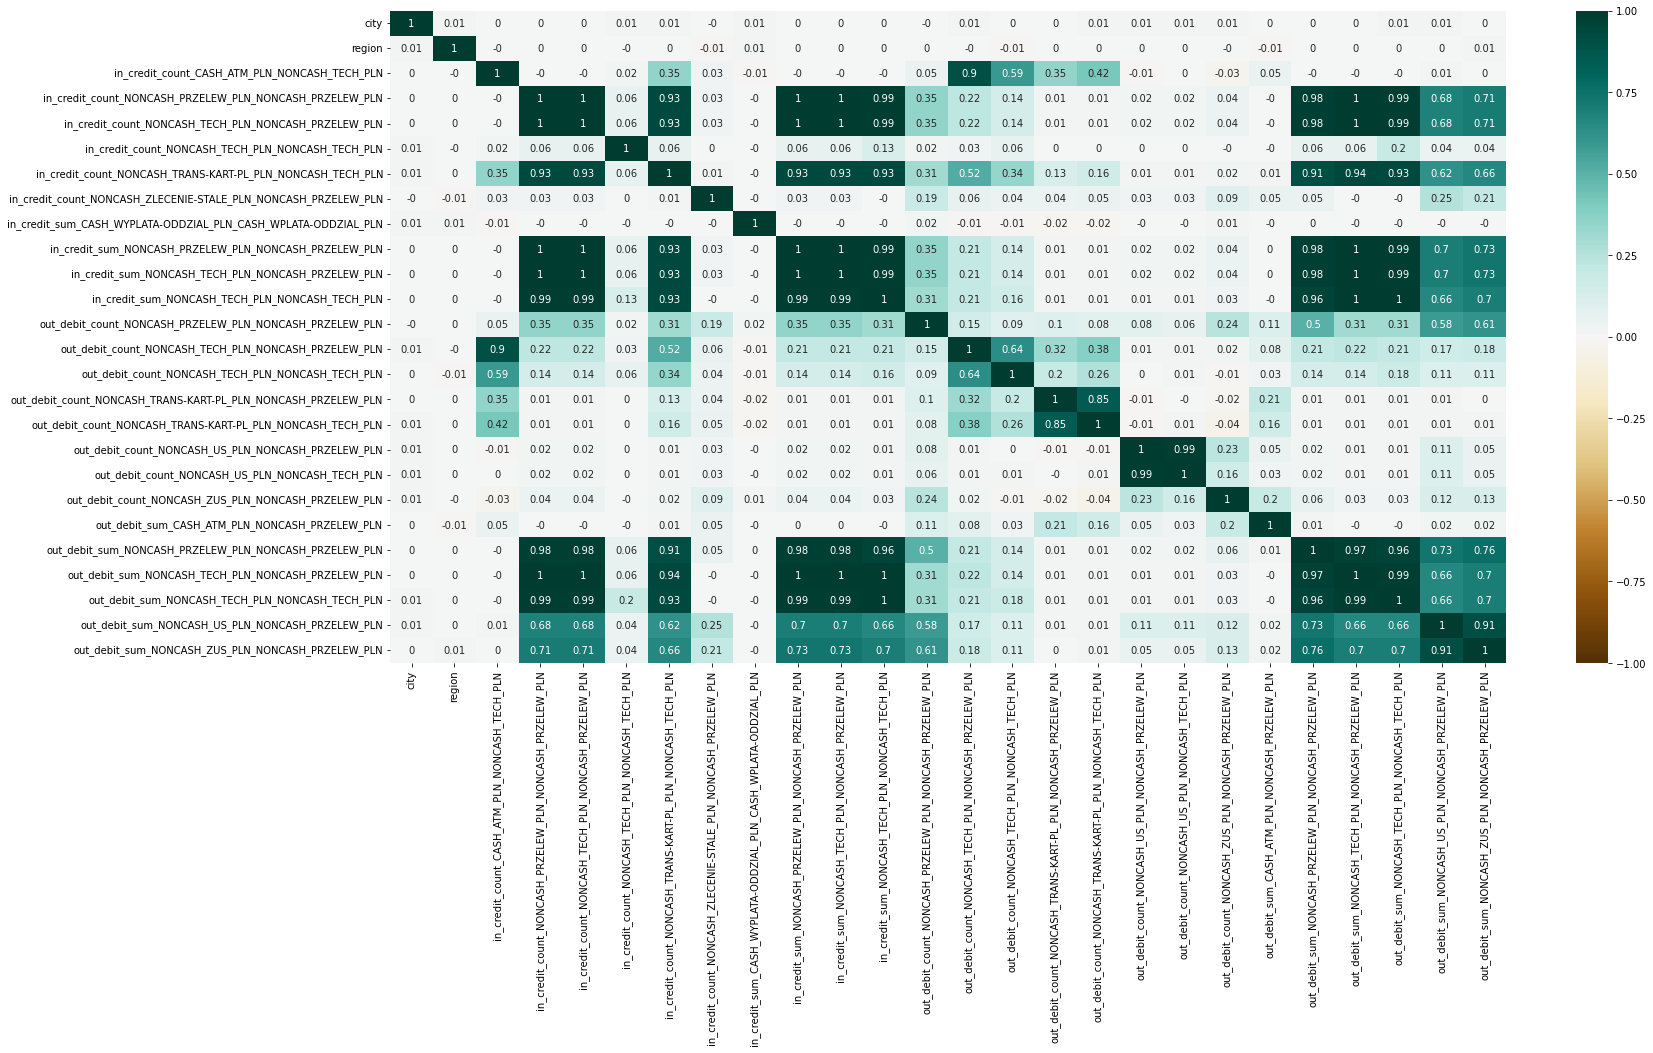

In [55]:
## Choosen variables correlation matrix

plt.figure(figsize=(25, 12))
sns.heatmap(x_pre.corr().round(2),vmin=-1, vmax=1, annot=True,cmap='BrBG')

In [56]:
## Droping of variables correlated together - drop criterion - lower feature importance
#Usuwamy zmienn wzajemnie skorelowane - kryterium do usunięcia niższe feature importance z drzewa decyzyjnego

x_pre.drop(['in_credit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            #'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'in_credit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'in_credit_sum_NONCASH_TECH_PLN_NONCASH_TECH_PLN',\
            'out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_sum_NONCASH_TECH_PLN_NONCASH_TECH_PLN',\
            'in_credit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',\
            'out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN'], axis=1, inplace=True)

## Checking of NA

x_pre.isna().sum()

city                                                              0
region                                                            0
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN                     0
in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN           0
in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                 0
in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN        0
in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN    0
in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN    0
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                0
out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN           0
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN              0
out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                 0
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN     0
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN        0
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN 

In [57]:
## Check of unique transactions number

x_pre.nunique()

city                                                                200
region                                                               16
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN                       612
in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN             637
in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                   652
in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN          616
in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN      424
in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN      865
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                13047
out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN             742
out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN                674
out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN                   672
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN       936
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN      

In [58]:
clients_tran_all_fin.head()

,is_individual_flag,city,region,in_credit_count_CASH_ATM_EUR_CASH_CDM_PLN,in_credit_count_CASH_ATM_EUR_CASH_UZNANIE_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_EUR,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_GBP,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_PLN,in_credit_count_CASH_ATM_EUR_CASH_WPLATA-ODDZIAL_USD,in_credit_count_CASH_ATM_EUR_NONCASH_BLIK-mobile_PLN,...,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_TECH_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_GBP,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_UZNANIE_USD,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_EUR,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_ZLECENIE-STALE_PLN
0,1,181,3,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,51,10,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,183,12,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,162,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,118,6,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X =x_pre.values
y = clients_tran_all_fin.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 322)
print(pd.Series(y).value_counts())

1    14993
0     1858
dtype: int64


In [60]:
## Data preprocessing - scaling

scaler = RobustScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
svc = SVC(probability=True)
svc.fit(X_train_sc, y_train)

SVC(probability=True)

In [61]:
rf = RandomForestClassifier(n_estimators=200, 
                           max_depth=25,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=25, n_estimators=200)

In [62]:
xgbm = xgb.XGBClassifier(max_depth = 25, 
                         eta = 1, 
                         silent =1,
                         objective= 'binary:logistic',
                         eval_metric='auc',
                         learning_rate=0.05, 
                         n_estimators =200
                        )

xgbm.fit(X_train_sc,  np.ravel(y_train))

[19:51:20] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=1,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [63]:
param = {'num_leaves':200, 'objective':'binary','max_depth':25,'learning_rate':.05,'max_bin':100, 'force_col_wise':'true'}
param['metric'] = ['auc', 'binary_logloss']

lgbm = lgb.LGBMClassifier(**param, feature_name=[x for x in x_pre.columns]
                            )

lgbm.fit(X_train_sc,  np.ravel(y_train))

/home/dsl/.local/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] Unknown parameter: feature_name


LGBMClassifier(feature_name=['city', 'region',
                             'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
                             'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
                             'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
                             'in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
                             'in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN',
                             'in_credit_sum_CASH_W...
                             'out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN',
                             'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN',
                             'out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
                             'out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN',
                             'out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN'],
               force_col_wise='true', learning_rate=0.05, 

In [65]:
## Models benchmark - sampling -> unbalanced

pred_svc=svc.predict(X_test_sc)
pred_rf=rf.predict(X_test_sc)
pred_lgbm=lgbm.predict(X_test_sc)
pred_xgbm=xgbm.predict(X_test_sc)

prob_svc=svc.predict_proba(X_test_sc)[:, 1]
prob_rf=rf.predict_proba(X_test_sc)[:, 1]
prob_lgbm=lgbm.predict_proba(X_test_sc)[:, 1]
prob_xgbm=xgbm.predict_proba(X_test_sc)[:, 1]

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, prob_rf))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, prob_svc))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, prob_lgbm))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, prob_xgbm))

AUC&ROC RF: 0.958793010049688
AUC&ROC SVC: 0.9235681996488212
AUC&ROC LGBM: 0.9632710053423992
AUC&ROC XGBM: 0.9621072589382448


In [66]:
print(metrics.classification_report(y_test, np.round(pred_rf)))
metrics.confusion_matrix(y_test, np.round(pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       355
           1       0.97      0.99      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.91      0.85      0.88      3371
weighted avg       0.96      0.96      0.96      3371



array([[ 256,   99],
       [  45, 2971]])

In [67]:
print(metrics.classification_report(y_test, np.round(pred_lgbm)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       355
           1       0.97      0.98      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.90      0.86      0.88      3371
weighted avg       0.96      0.96      0.96      3371



array([[ 262,   93],
       [  50, 2966]])

In [68]:
print(metrics.classification_report(y_test, np.round(pred_xgbm)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm))

              precision    recall  f1-score   support

           0       0.83      0.73      0.77       355
           1       0.97      0.98      0.98      3016

    accuracy                           0.96      3371
   macro avg       0.90      0.85      0.88      3371
weighted avg       0.95      0.96      0.95      3371



array([[ 258,   97],
       [  53, 2963]])

In [69]:
print(metrics.classification_report(y_test, np.round(pred_svc)))
metrics.confusion_matrix(y_test, np.round(pred_svc))

              precision    recall  f1-score   support

           0       0.87      0.23      0.36       355
           1       0.92      1.00      0.95      3016

    accuracy                           0.91      3371
   macro avg       0.89      0.61      0.66      3371
weighted avg       0.91      0.91      0.89      3371



array([[  80,  275],
       [  12, 3004]])

In [70]:
## Undersampling 

undersample = resample(X_train[y_train == 1],
                       n_samples = len(y_train[y_train == 0]))

In [71]:
X_train_und = np.concatenate([undersample, X_train[y_train == 0]])
y_train_und = np.append(np.ones(len(y_train[y_train == 0])),
                          np.zeros(len(y_train[y_train == 0])))

In [72]:
print(pd.Series(y_train_und).value_counts())

1.0    1503
0.0    1503
dtype: int64


In [85]:
scaler = RobustScaler().fit(X_train_und)
X_train_und_sc = scaler.transform(X_train_und)
X_test_und_sc = scaler.transform(X_test)

svc_und = SVC(probability=True)
svc_und.fit(X_train_und_sc, y_train_und)

SVC(probability=True)

In [87]:
rf_und = RandomForestClassifier(n_estimators=30, 
                           max_depth=15,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf_und.fit(X_train_und_sc, y_train_und)

RandomForestClassifier(max_depth=15, n_estimators=30)

In [80]:
xgbm_und = xgb.XGBClassifier(max_depth = 15, 
                         eta = 1, 
                         silent =1,
                         objective= 'binary:logistic',
                         eval_metric='auc',
                         learning_rate=0.05, 
                         n_estimators =30
                        )

xgbm_und.fit(X_train_und_sc,  np.ravel(y_train_und))

[19:44:40] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=1,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [139]:
param = {'num_leaves':30, 'objective':'binary','max_depth':15,'learning_rate':.03,'max_bin':100}
param['metric'] = ['auc', 'binary_logloss']

lgbm_und = lgb.LGBMClassifier(**param)

lgbm_und.fit(X_train_und_sc,  np.ravel(y_train_und), feature_name=[x for x in x_pre.columns])

LGBMClassifier(learning_rate=0.03, max_bin=100, max_depth=15,
               metric=['auc', 'binary_logloss'], num_leaves=30,
               objective='binary')

In [88]:
## Models benchmark - sampling -> undersampling

pred_svc_und=svc_und.predict(X_test_und_sc)
pred_rf_und=rf_und.predict(X_test_und_sc)
pred_lgbm_und=lgbm_und.predict(X_test_und_sc)
pred_xgbm_und=xgbm_und.predict(X_test_und_sc)

prob_svc_und=svc_und.predict_proba(X_test_und_sc)[:, 1]
prob_rf_und=rf_und.predict_proba(X_test_und_sc)[:, 1]
prob_lgbm_und=lgbm_und.predict_proba(X_test_und_sc)[:, 1]
prob_xgbm_und=xgbm_und.predict_proba(X_test_und_sc)[:, 1]

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, prob_rf_und))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, prob_svc_und))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, prob_xgbm_und))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, prob_lgbm_und))

AUC&ROC RF: 0.9553923674674037
AUC&ROC SVC: 0.8623613030970971
AUC&ROC XGBM: 0.9540413568946837
AUC&ROC LGBM: 0.9582298165651735


In [89]:
print(metrics.classification_report(y_test, np.round(pred_rf_und)))
metrics.confusion_matrix(y_test, np.round(pred_rf_und))

              precision    recall  f1-score   support

           0       0.54      0.87      0.66       355
           1       0.98      0.91      0.95      3016

    accuracy                           0.91      3371
   macro avg       0.76      0.89      0.80      3371
weighted avg       0.94      0.91      0.92      3371



array([[ 310,   45],
       [ 269, 2747]])

In [90]:
print(metrics.classification_report(y_test, np.round(pred_xgbm_und)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm_und))

              precision    recall  f1-score   support

           0       0.51      0.88      0.64       355
           1       0.99      0.90      0.94      3016

    accuracy                           0.90      3371
   macro avg       0.75      0.89      0.79      3371
weighted avg       0.93      0.90      0.91      3371



array([[ 314,   41],
       [ 306, 2710]])

In [91]:
print(metrics.classification_report(y_test, np.round(pred_lgbm_und)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm_und))

              precision    recall  f1-score   support

           0       0.56      0.88      0.69       355
           1       0.99      0.92      0.95      3016

    accuracy                           0.92      3371
   macro avg       0.77      0.90      0.82      3371
weighted avg       0.94      0.92      0.92      3371



array([[ 313,   42],
       [ 243, 2773]])

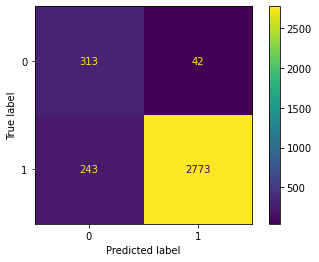

In [92]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lgbm_und, X_test_und_sc, y_test)
plt.show()

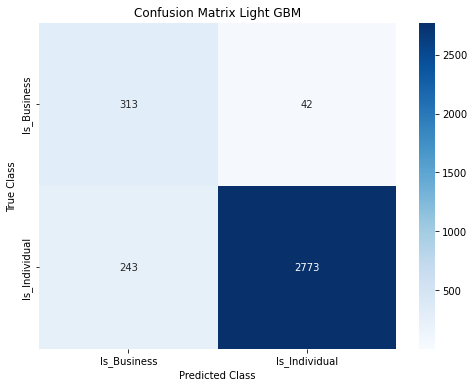

In [93]:
## Confusion Matrix chart

cm = metrics.confusion_matrix(y_test, np.round(pred_lgbm_und))
labels = ['Is_Business', 'Is_Individual']
plt.figure(figsize=(8,6))
sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2)
plt.title('Confusion Matrix Light GBM')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

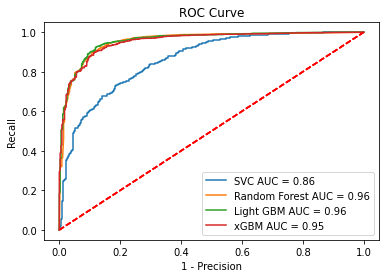

In [95]:
## Models benchmark - ROC chart

def plot_roc(y_test, prob, model_name = ""):
    
    fpr, recall, tresh = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)

    plt.plot(fpr, recall, label = "{} AUC = {}".format(model_name, auc.round(2)))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("1 - Precision")
    plt.ylabel("Recall")
    plt.title("ROC Curve")
    plt.legend()

plot_roc(y_test, prob_svc_und, model_name = "SVC")
plot_roc(y_test, prob_rf_und, model_name = "Random Forest")
plot_roc(y_test, prob_lgbm_und, model_name = "Light GBM")
plot_roc(y_test, prob_xgbm_und, model_name = "xGBM")

In [96]:
## Oversampling with SMOTE methode: Synthetic Minority Over-sampling Technique

sm = SMOTE(sampling_strategy=1)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [97]:
y_train_sm = pd.DataFrame(y_train_sm)
y_train_sm.columns = ['Class']
y_train_sm['Class'].value_counts()

1    11977
0    11977
Name: Class, dtype: int64

In [98]:
scaler = RobustScaler().fit(X_train_sm)
X_train_sm_sc = scaler.transform(X_train_sm)
X_test_sm_sc = scaler.transform(X_test)

svc_sm = SVC(probability=True)
svc_sm.fit(X_train_sm_sc, y_train_sm)

/home/dsl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(probability=True)

In [99]:
rf_sm = RandomForestClassifier(n_estimators=200, 
                           max_depth=25,
                           min_samples_split=2,
                           bootstrap=True, 
                           max_features = 'auto') 
rf_sm.fit(X_train_sm_sc, y_train_sm)

<ipython-input-99-1e86beb575c7>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_sm.fit(X_train_sm_sc, y_train_sm)


RandomForestClassifier(max_depth=25, n_estimators=200)

In [103]:
param={'max_depth':15, 'eta':1, 'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05, 'n_estimators':30}

xgbm_sm = xgb.XGBClassifier(**param) 

xgbm_sm.fit(X_train_sm_sc,  np.ravel(y_train_sm))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=1,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [140]:
param = {'num_leaves':200, 'objective':'binary','max_depth':25,'learning_rate':.05,'max_bin':100}
param['metric'] = ['auc', 'binary_logloss']

lgbm_sm = lgb.LGBMClassifier(**param)

lgbm_sm.fit(X_train_sm_sc,  np.ravel(y_train_sm), feature_name=[x for x in x_pre.columns])

LGBMClassifier(learning_rate=0.05, max_bin=100, max_depth=25,
               metric=['auc', 'binary_logloss'], num_leaves=200,
               objective='binary')

In [108]:
## Models benchmark - sampling -> oversampling

pred_svc_sm=svc_sm.predict(X_test_sm_sc)
pred_rf_sm=rf_sm.predict(X_test_sm_sc)
pred_lgbm_sm=lgbm_sm.predict(X_test_sm_sc)
pred_xgbm_sm=xgbm_sm.predict(X_test_sm_sc)

prob_svc_sm=svc_sm.predict_proba(X_test_sm_sc)[:, 1]
prob_rf_sm=rf_sm.predict_proba(X_test_sm_sc)[:, 1]
prob_lgbm_sm=lgbm_sm.predict_proba(X_test_sm_sc)[:, 1]
prob_xgbm_sm=xgbm_sm.predict_proba(X_test_sm_sc)[:, 1]

print("AUC&ROC RF:", metrics.roc_auc_score(y_test, prob_rf_sm))
print("AUC&ROC SVC:", metrics.roc_auc_score(y_test, prob_svc_sm))
print("AUC&ROC XGBM:", metrics.roc_auc_score(y_test, prob_xgbm_sm))
print("AUC&ROC LGBM:", metrics.roc_auc_score(y_test, prob_lgbm_sm))

AUC&ROC RF: 0.9579477528299771
AUC&ROC SVC: 0.8967534650876079
AUC&ROC XGBM: 0.9545004109537865
AUC&ROC LGBM: 0.9572127059438862


In [109]:
print(metrics.classification_report(y_test, np.round(pred_rf_sm)))
metrics.confusion_matrix(y_test, np.round(pred_rf_sm))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       355
           1       0.97      0.96      0.97      3016

    accuracy                           0.94      3371
   macro avg       0.84      0.87      0.85      3371
weighted avg       0.95      0.94      0.94      3371



array([[ 272,   83],
       [ 107, 2909]])

In [110]:
print(metrics.classification_report(y_test, np.round(pred_xgbm_sm)))
metrics.confusion_matrix(y_test, np.round(pred_xgbm_sm))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       355
           1       0.98      0.96      0.97      3016

    accuracy                           0.94      3371
   macro avg       0.83      0.88      0.85      3371
weighted avg       0.95      0.94      0.94      3371



array([[ 281,   74],
       [ 125, 2891]])

In [111]:
print(metrics.classification_report(y_test, np.round(pred_lgbm_sm)))
metrics.confusion_matrix(y_test, np.round(pred_lgbm_sm))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       355
           1       0.97      0.97      0.97      3016

    accuracy                           0.95      3371
   macro avg       0.86      0.88      0.87      3371
weighted avg       0.95      0.95      0.95      3371



array([[ 278,   77],
       [  95, 2921]])

In [112]:
## Feature importance by local importance method LIME

cats = pd.get_dummies(x_pre, drop_first=True).columns

In [113]:
cats

Index(['city', 'region', 'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit

In [114]:
x_pre.columns

Index(['city', 'region', 'in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN',
       'in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN',
       'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN',
       'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN',
       'out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN',
       'out_debit

In [115]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_und_sc, 
                                                   feature_names= x_pre.columns,
                                                   class_names = ['is_individual_flag'],
                                                   categorical_features= cats,
                                                   verbose = True,
                                                   mode = 'regression'
                                                  )

In [116]:
i = 12

expl = explainer.explain_instance(X_test_und_sc[i], lgbm_und.predict, num_features= 15)

Intercept 0.08662483985399111
Prediction_local [0.77889494]
Right: 1.0


In [117]:
expl.show_in_notebook(show_table=True)

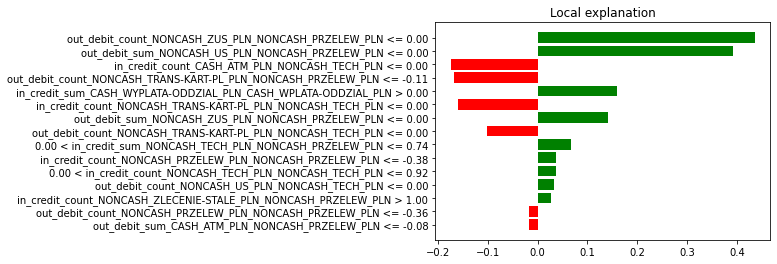

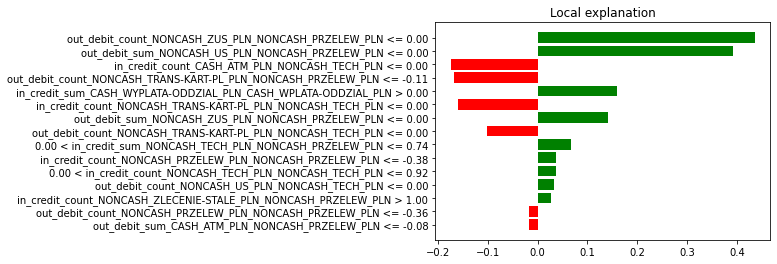

In [118]:
expl.as_pyplot_figure(label=1)

In [119]:
## What are this cities (important variable for business segment forecasting) - when lack of data variable is filled with 0's

x_pre[x_pre["city"]<0.5]

,city,region,in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,in_credit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN,in_credit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN,in_credit_count_NONCASH_ZLECENIE-STALE_PLN_NONCASH_PRZELEW_PLN,in_credit_sum_CASH_WYPLATA-ODDZIAL_PLN_CASH_WPLATA-ODDZIAL_PLN,in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN,out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN,out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_TECH_PLN,out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_CASH_ATM_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN
157,0,11,12.0,43.5,12.0,12.0,0.0,9376.89,36539.130,48.5,12.0,12.0,323,323,0,0,11882.32,0.00,0.00
464,0,10,0.0,3.0,0.0,0.0,0.0,0.00,752.630,29.0,10.0,0.0,7,0,0,22,0.00,20.62,12557.26
579,0,7,1.0,48.0,1.0,1.0,48.0,0.00,41778.310,89.0,7.0,7.0,253,253,0,4,5373.15,0.00,1285.63
730,0,13,0.0,92.5,12.0,0.0,0.0,0.00,221491.205,119.0,12.0,12.0,0,0,0,0,0.00,0.00,0.00
1202,0,5,0.0,15.0,80.0,0.0,0.0,0.00,9026.655,81.5,80.0,80.0,0,0,0,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15071,0,1,0.0,0.0,12.0,0.0,0.0,0.00,1460.310,0.0,12.0,12.0,0,0,0,0,0.00,0.00,0.00
15302,0,4,6.0,14.5,6.0,6.0,14.5,0.00,20894.645,52.5,32.0,32.0,153,153,0,0,27124.47,0.00,0.00
15523,0,4,1.0,23.0,1.0,0.0,23.0,0.00,28481.440,1.0,16.0,16.0,0,0,0,0,531.39,0.00,0.00
15790,0,7,0.0,9.0,0.0,0.0,0.0,0.00,3892.890,23.0,4.0,0.0,39,0,0,0,2175.52,0.00,0.00


In [120]:
## Feature importance according to Light GBM

feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head(20)

,FeatureImportance
out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN,0.446722
out_debit_count_NONCASH_TRANS-KART-PL_PLN_NONCASH_PRZELEW_PLN,0.036369
in_credit_count_CASH_ATM_PLN_NONCASH_TECH_PLN,0.034235
in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.027749
out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.025010
city,0.019224
out_debit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN,0.019134
out_debit_sum_NONCASH_PRZELEW_PLN_NONCASH_PRZELEW_PLN,0.018655
out_debit_count_NONCASH_US_PLN_NONCASH_TECH_PLN,0.016595
out_debit_count_NONCASH_US_PLN_NONCASH_PRZELEW_PLN,0.015126


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

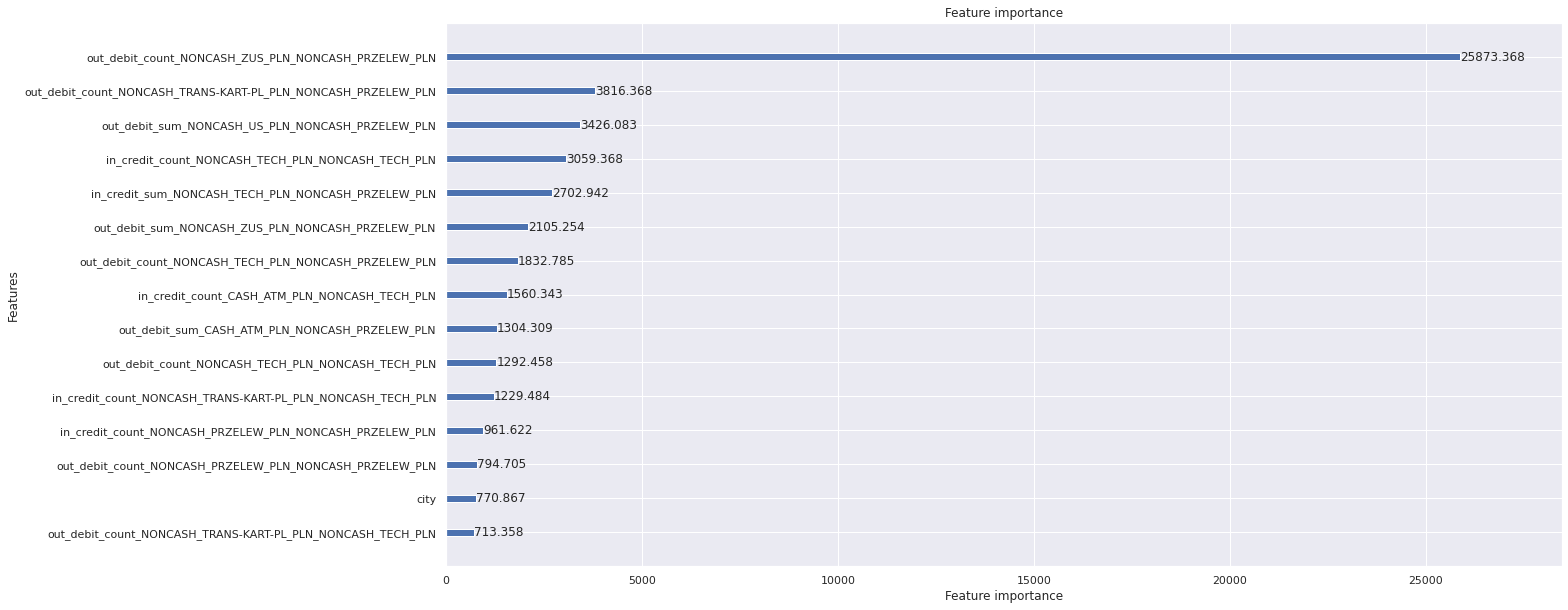

In [141]:
lgb.plot_importance(lgbm_und, max_num_features=15, importance_type='gain', figsize=(20,10))

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN'>

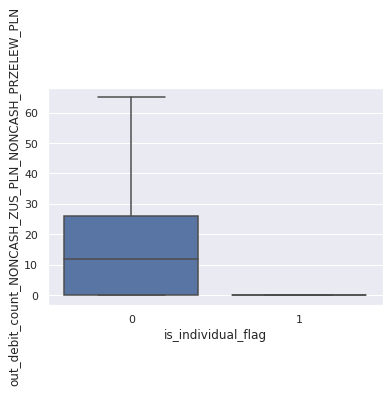

In [122]:
## Chart of distribution of most important variables on target variable - client segment

sns.set(style="darkgrid")
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_count_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1), showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN'>

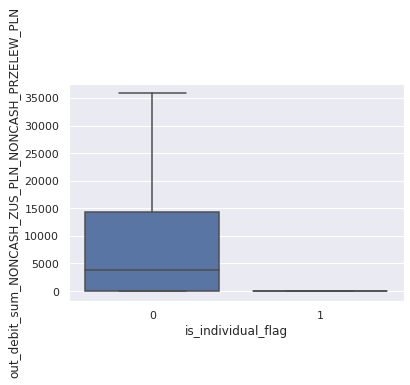

In [123]:
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_sum_NONCASH_ZUS_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1), showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN'>

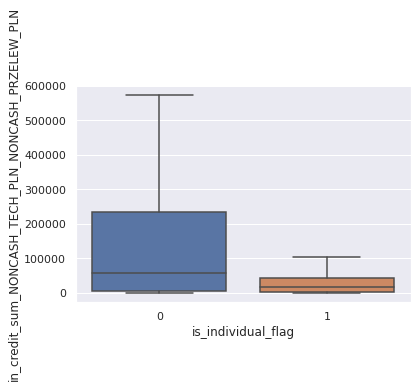

In [124]:
sns.boxplot(x = 'is_individual_flag', y = 'in_credit_sum_NONCASH_TECH_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN'>

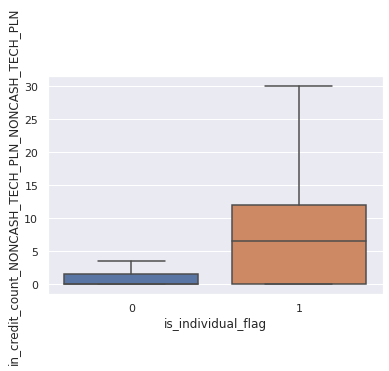

In [126]:
sns.boxplot(x = 'is_individual_flag', y = 'in_credit_count_NONCASH_TECH_PLN_NONCASH_TECH_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

<AxesSubplot:xlabel='is_individual_flag', ylabel='out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN'>

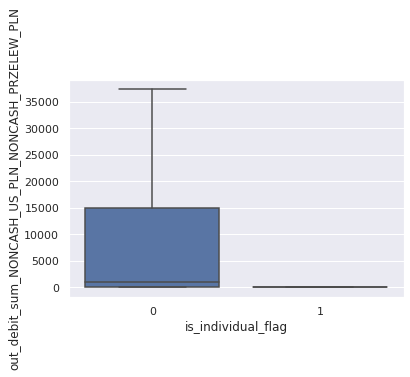

In [127]:
sns.boxplot(x = 'is_individual_flag', y = 'out_debit_sum_NONCASH_US_PLN_NONCASH_PRZELEW_PLN', data = pd.concat([clients_tran_all_fin["is_individual_flag"],x_pre],axis=1),showfliers=False)

In [128]:
## Scoring on new data

In [129]:
clients_tst_tran_out=pd.merge(clients_test,tran_agg_out,left_on='cst_id',right_on='out_debit_cst_id',how='left')
clients_tst_tran_out.head()

,cst_id,main_id,city,region,out_debit_cst_id,out_credit_cst_id,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,out_debit_amt_curr_count,out_debit_amt_curr_sum
0,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,CASH,ATM,PLN,PLN,12.0,3235.55,12.0,3235.55
1,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,FEE,PLN,PLN,1.0,2.50,1.0,2.50
2,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,PRZELEW,PLN,PLN,4.0,898.16,4.0,898.16
3,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,TECH,PLN,PLN,13.0,1285.25,13.0,1334.25
4,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,62314880.0,-1.0,NONCASH,TRANS-KART-PL,PLN,PLN,34.0,2823.13,34.0,2823.13


In [130]:
clients_tst_tran_out.drop(['out_debit_cst_id', 'out_credit_cst_id'], axis=1, inplace=True)

In [131]:
clients_tst_tran_all=pd.merge(clients_tst_tran_out,tran_agg_in,left_on='cst_id',right_on='in_credit_cst_id',how='left')
clients_tst_tran_all.head()

,cst_id,main_id,city,region,out_trans_type,out_trans_category,out_credit_curr,out_debit_curr,out_credit_amt_curr_count,out_credit_amt_curr_sum,...,in_debit_cst_id,in_credit_cst_id,in_trans_type,in_trans_category,in_credit_curr,in_debit_curr,in_credit_amt_curr_count,in_credit_amt_curr_sum,in_debit_amt_curr_count,in_debit_amt_curr_sum
0,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,CASH,ATM,PLN,PLN,12.0,3235.55,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
1,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,FEE,PLN,PLN,1.0,2.50,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
2,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,PRZELEW,PLN,PLN,4.0,898.16,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
3,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,TECH,PLN,PLN,13.0,1285.25,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29
4,62314880,4448723273,Tarnowskie Góry,Warmińsko - mazurskie,NONCASH,TRANS-KART-PL,PLN,PLN,34.0,2823.13,...,-1.0,62314880.0,NONCASH,PRZELEW,PLN,PLN,15.0,14014.29,15.0,14014.29


In [132]:
clients_tst_tran_all_piv=clients_tst_tran_all.pivot_table(index=["cst_id","main_id", "city", "region"], 
                       columns=["out_trans_type", "out_trans_category", "out_credit_curr", "out_debit_curr", "in_trans_type", "in_trans_category", "in_credit_curr", "in_debit_curr"],
                       fill_value=0,
                       values=np.r_[clients_tst_tran_all.columns[11:13],clients_tst_tran_all.columns[19:21]]
                      )

In [133]:
clients_tst_tran_all_fin = pd.DataFrame(clients_tst_tran_all_piv.to_records())

In [134]:
clients_tst_tran_all_fin.columns = [hdr.replace("('", "").replace("')", "").replace(", ''", "").replace("', '", "_")  \
                     for hdr in clients_tst_tran_all_fin.columns]
clients_tst_tran_all_fin.head()

,cst_id,main_id,city,region,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_CDM_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_EUR_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_GBP_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_CASH_WPLATA-ODDZIAL_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_NONCASH_BLIK-mobile_PLN_PLN,in_credit_amt_curr_sum_CASH_ATM_PLN_PLN_NONCASH_FEE_PLN_PLN,...,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_UZNANIE_EUR_EUR,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_UZNANIE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZLECENIE-STALE_PLN_PLN_NONCASH_ZLECENIE-STALE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_CASH_CDM_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_CASH_WPLATA-ODDZIAL_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_PRZELEW_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_PRZELEW-ODDZIAL_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_TECH_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_UZNANIE_PLN_PLN,out_debit_amt_curr_sum_NONCASH_ZUS_PLN_PLN_NONCASH_ZLECENIE-STALE_PLN_PLN
0,10391383,8235906434,Białogard,Podlaskie,878.69,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12085807,4908307042,Radom,Opolskie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13319456,4618118193,Ostrów Wielkopolski,Podkarpackie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13513850,2259929186,Rzeszów,Śląskie,1010.31,0.0,884.67,0.0,0.0,0.0,...,0.0,4297.09,4297.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15331755,5000503106,Zduńska Wola,Lubuskie,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
clients_tst_tran_all_fin = convert(clients_tst_tran_all_fin) 
clients_tst_tran_all_fin=clients_tst_tran_all_fin.rename(columns=lambda s: s.replace('_amt_curr','').replace('_PLN_PLN',''))
x_tst_pre=pd.concat([pd.DataFrame(clients_tst_tran_all_fin,columns=x_pre.columns),clients_tst_tran_all_fin["main_id"]],axis=1)

x_tst_pre=x_tst_pre.fillna(0)
X_valid = x_tst_pre.iloc[:,:-1].values

In [136]:
scaler = RobustScaler().fit(X_train_und)
X_valid_sc = scaler.transform(X_valid)

In [137]:
predictions = lgbm_und.predict(X_valid_sc)

pred_lgbm = pd.DataFrame({'main_id': x_tst_pre.iloc[:,-1].values, 'is_individual_pred': predictions})

client_tst_pred=pd.merge(clients_test,pred_lgbm,left_on='main_id',right_on='main_id',how='left')

client_tst_pred.to_csv('dspo_clients_test_pred.csv', index=False)